In [1]:
import pandas as pd
import numpy as np
import glob
import os
import bz2
import codecs
import json
import matplotlib.pylab as plt
%matplotlib inline

In [63]:
def text_files_iterator(sources, verbose=False):
    """Iterate over lines in text files. src can contain wildcards. Files may be compressed with bzip2."""
    for filename in [fn for src in sources for fn in glob.glob(src)]:
        if verbose: print('Reading %s ' % filename)
        ext = os.path.splitext(filename)[1]
        if ext == '.bz2':
            with closing(bz2.BZ2File(filename, 'rb')) as data_file:
                reader = codecs.getreader("utf-8")
                for line in reader(data_file):
                    yield line
        else:
            with open(filename, 'r') as file:
                for line in file:
                    yield line


In [64]:
def load_processed_data(sources):
    data = [json.loads(line) for line in text_files_iterator(sources, verbose=True)]
    return data

In [65]:
data_list = load_processed_data([
    '/home/faheyc/nautilus/braindemo/processed-data/braindemo-processed-data-20170425-161554.json',
    '/home/faheyc/nautilus/braindemo/processed-data/braindemo-processed-data-20170425-170732.json',
    ])

Reading /home/faheyc/nautilus/braindemo/processed-data/braindemo-processed-data-20170425-161554.json 
Reading /home/faheyc/nautilus/braindemo/processed-data/braindemo-processed-data-20170425-170732.json 


In [66]:
df = pd.DataFrame(data_list)

In [67]:
df.head()

,ap,att,device_id,timestamp
0,1,29,192.168.1.4,1493151352085
1,1,78,192.168.1.8,1493151355318
2,1,77,192.168.1.8,1493151356314
3,1,81,192.168.1.9,1493151357221
4,2,7,192.168.1.6,1493151356738


In [68]:
df.device_id.value_counts()

192.168.1.4     3745
192.168.1.9     3424
192.168.1.7     3299
192.168.1.6     3228
192.168.1.8     2945
192.168.1.5     2440
192.168.1.12    2008
192.168.1.13    1684
Name: device_id, dtype: int64

In [70]:
(df.timestamp.max() - df.timestamp.min())/1000/60

66

In [132]:
def fix_gap(t0, t1, delta_t, last_valid_att):
    t = np.arange(t0 + delta_t, t1 - delta_t, delta_t)
    att = np.clip(np.random.normal(loc=last_valid_att, scale=10.0, size=len(t)), 0.0, 100.0)
    return zip(t, att)

In [133]:
fix_gap(1493154128266, 1493154128266+30000, 1000, 50)

[(1493154129266, 50.947135514343124),
 (1493154130266, 45.556151752569889),
 (1493154131266, 52.238877829319456),
 (1493154132266, 44.606320549522152),
 (1493154133266, 48.119989109744132),
 (1493154134266, 47.524619544970669),
 (1493154135266, 46.471437302300629),
 (1493154136266, 56.512321327659158),
 (1493154137266, 56.725230796455698),
 (1493154138266, 44.295587855346696),
 (1493154139266, 48.583076489306563),
 (1493154140266, 45.421933738386038),
 (1493154141266, 28.430851847212082),
 (1493154142266, 36.550960207146147),
 (1493154143266, 33.759152770327432),
 (1493154144266, 73.694614630607447),
 (1493154145266, 49.835882475311664),
 (1493154146266, 42.138525256697406),
 (1493154147266, 46.232871735746166),
 (1493154148266, 68.31334098690607),
 (1493154149266, 51.574257154415925),
 (1493154150266, 49.48913318631125),
 (1493154151266, 41.73832160556853),
 (1493154152266, 49.022509844744249),
 (1493154153266, 59.971866199319834),
 (1493154154266, 63.653288016534979),
 (1493154155266

In [95]:
device_id = '192.168.1.8'
ts = df[df.device_id==device_id].set_index(['timestamp'])['att']

In [154]:
def clean_timeseries(ts, t0, t1):
    new_ts = []
    last_timestamp = None
    last_valid_att = 50.0
    full_ts = [(t0, None)] + list(ts.iteritems()) + [(t1, None)]
    for timestamp, att in full_ts:
        if att == -1:
            att = None
        if last_timestamp is not None:
            gap = timestamp - last_timestamp
            if gap > 10000:
                print('Fixing gap of %d ms at timestamp %d' % (gap, last_timestamp))
                new_points = fix_gap(last_timestamp, timestamp, 1000, last_valid_att)
                new_ts.extend(new_points)
        last_timestamp = timestamp
        if att is not None:
            last_valid_att = att
            new_ts.append((timestamp, att))
    return pd.Series(index=[d[0] - t0 for d in new_ts], data=[d[1] for d in new_ts])

In [155]:
new_ts = clean_timeseries(ts, df.timestamp.min(), df.timestamp.max())

Fixing gap of 284523 ms at timestamp 1493152816967
Fixing gap of 13028 ms at timestamp 1493153762445
Fixing gap of 52890 ms at timestamp 1493154400529
Fixing gap of 201833 ms at timestamp 1493155128463


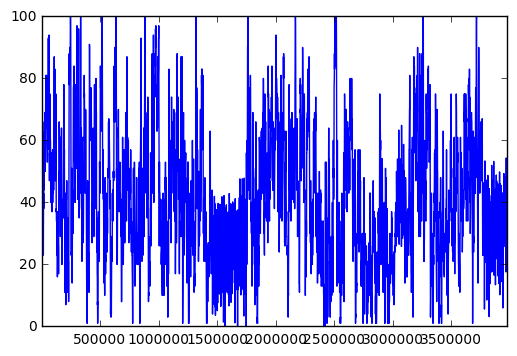

In [156]:
new_ts.plot()

Fixing gap of 1203277 ms at timestamp 1493151351089
Fixing gap of 120999 ms at timestamp 1493152747167
Fixing gap of 289981 ms at timestamp 1493154252157
Fixing gap of 41995 ms at timestamp 1493154613141
Fixing gap of 68049 ms at timestamp 1493154938111
Fixing gap of 117038 ms at timestamp 1493155024124
Fixing gap of 132174 ms at timestamp 1493155198122
Fixing gap of 2133570 ms at timestamp 1493151351089
Fixing gap of 53048 ms at timestamp 1493154399272
Fixing gap of 42571 ms at timestamp 1493152227385
Fixing gap of 22911 ms at timestamp 1493152817595
Fixing gap of 101644 ms at timestamp 1493152843448
Fixing gap of 52766 ms at timestamp 1493154394889
Fixing gap of 35311 ms at timestamp 1493155294985
Fixing gap of 1207905 ms at timestamp 1493151351089
Fixing gap of 271332 ms at timestamp 1493152745944
Fixing gap of 52043 ms at timestamp 1493154400215
Fixing gap of 10114 ms at timestamp 1493155320182
Fixing gap of 52982 ms at timestamp 1493154399706
Fixing gap of 367247 ms at timestamp 1

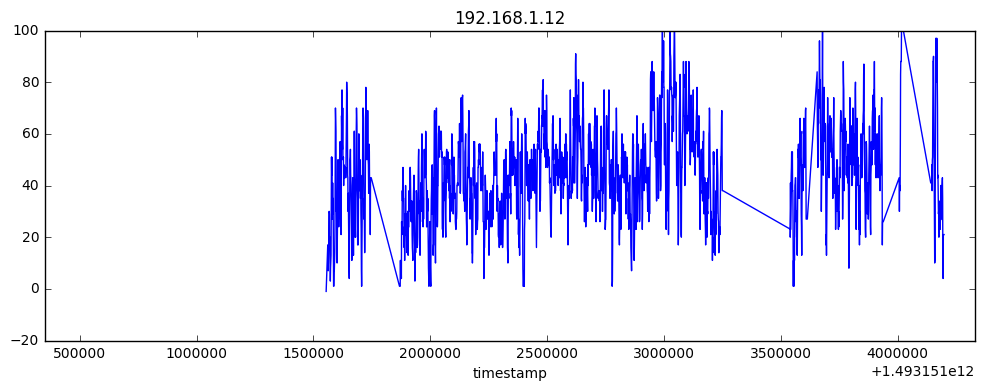

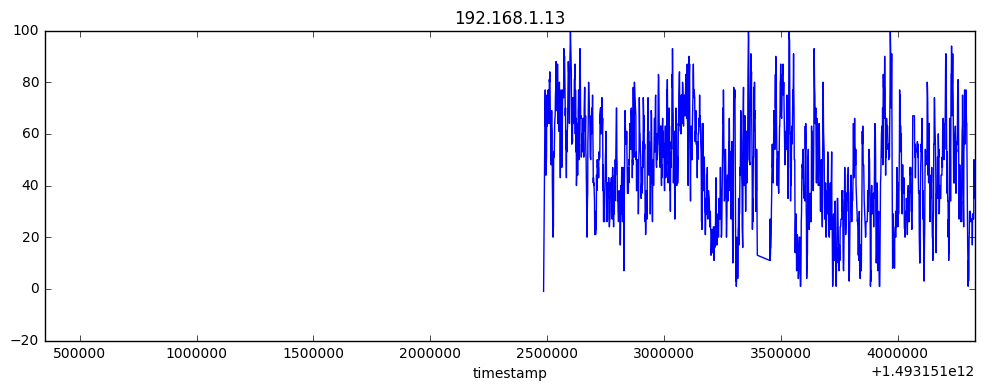

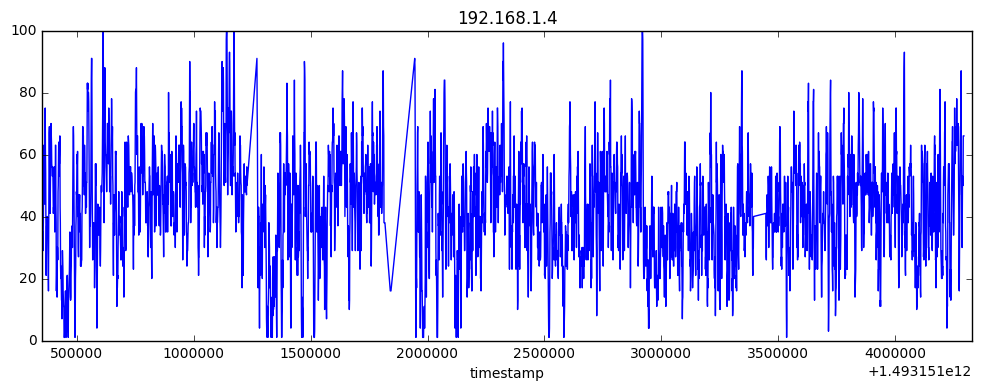

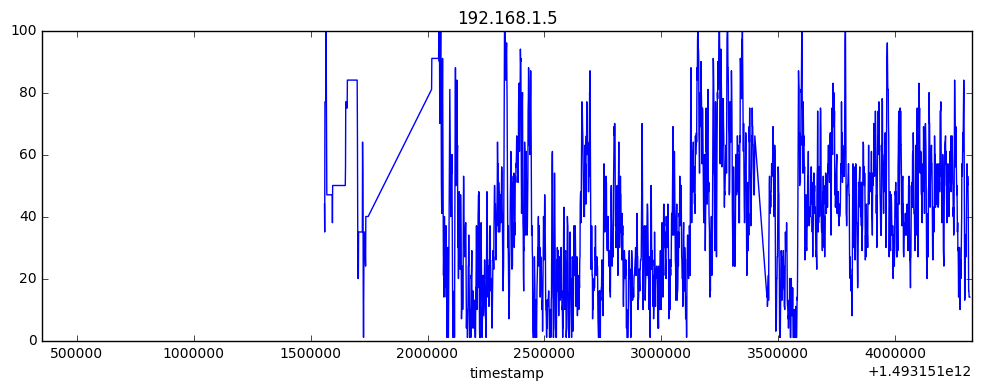

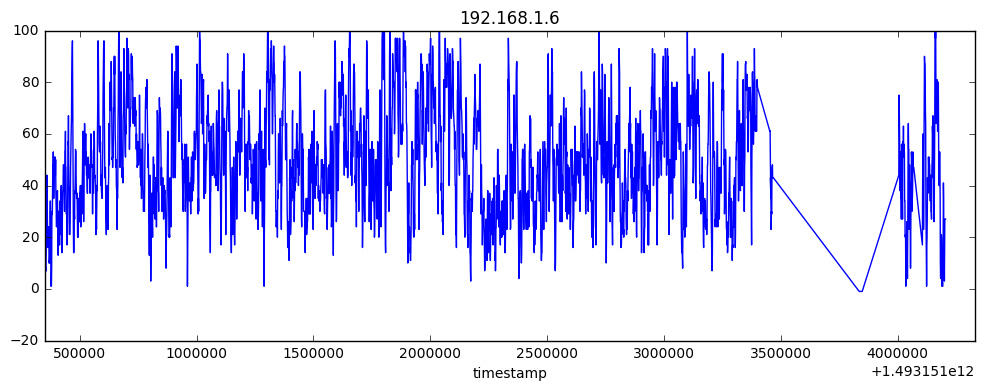

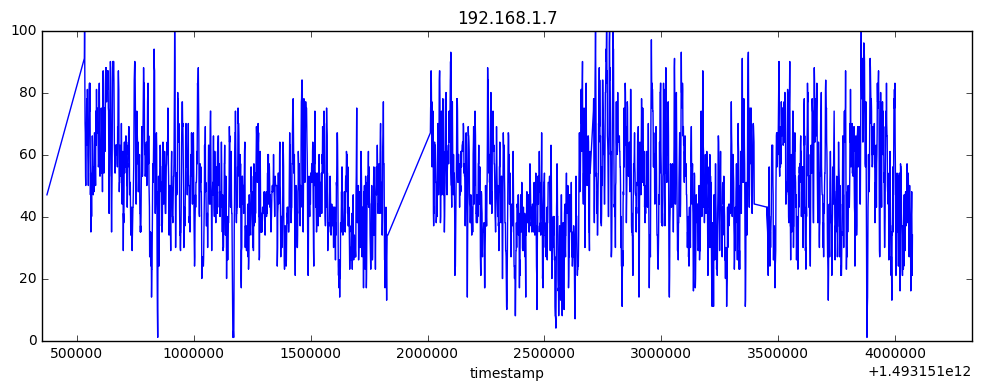

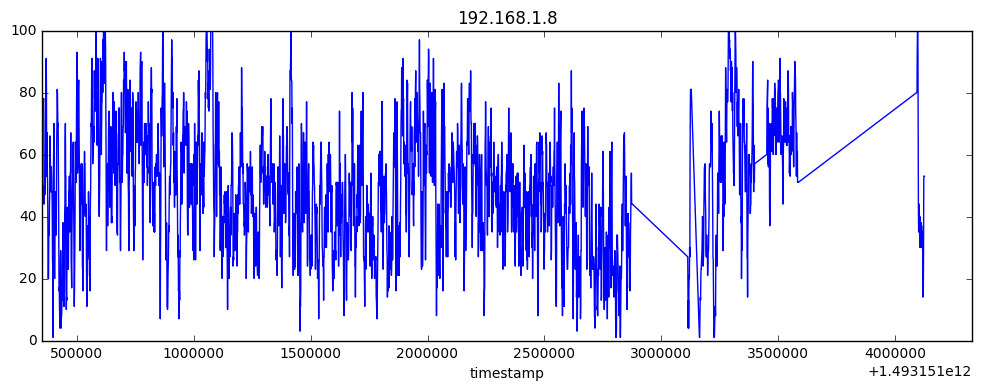

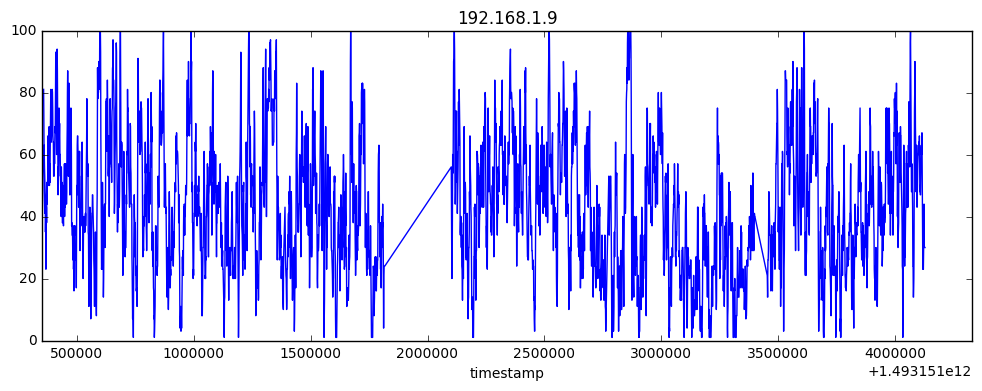

In [160]:
ts_range = [df.timestamp.min(), df.timestamp.max()]
for device_index, device_id in enumerate(sorted(df.device_id.value_counts().index.values)):
    ts = df[df.device_id==device_id].set_index(['timestamp'])['att']
    fig = plt.figure(figsize=(12,4))
    cleaned_ts = clean_timeseries(ts, ts_range[0], ts_range[1])
    cleaned_ts.to_csv('cleaned_data_%04d.csv' % device_index)
#     cleaned_ts.plot(xlim=ts_range)
    ts.plot(xlim=ts_range)
    plt.title(device_id)